# Sapiens human antibody language model: MLM fine-tuning

This notebook fine-tunes the Sapiens heavy chain model on a dataset of SARS-CoV-2-binding sequences.

No need for a GPU, the Sapiens model is just 2.2MB! On a CPU, it should take just a minute for a few thousand sequences.

Try out this notebook in your browser: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Merck/Sapiens/main?labpath=notebooks%2F03_sapiens_antibody_vh_mlm_finetuning.ipynb)

In [1]:
# Install dependencies
!pip install transformers[torch] datasets scikit-learn pandas seaborn

zsh:1: no matches found: transformers[torch]


In [2]:
!wget -O CovAbDab.csv https://opig.stats.ox.ac.uk/webapps/covabdab/static/downloads/CoV-AbDab_080224.csv

--2025-05-10 19:29:03--  https://opig.stats.ox.ac.uk/webapps/covabdab/static/downloads/CoV-AbDab_080224.csv
Resolving opig.stats.ox.ac.uk (opig.stats.ox.ac.uk)... 163.1.32.59
Connecting to opig.stats.ox.ac.uk (opig.stats.ox.ac.uk)|163.1.32.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8467893 (8,1M) [text/csv]
Saving to: ‘CovAbDab.csv’

CovAbDab.csv        100%[===================>]   8,08M  2,61MB/s    in 3,1s    

2025-05-10 19:29:07 (2,61 MB/s) - ‘CovAbDab.csv’ saved [8467893/8467893]



In [3]:
!head -3 CovAbDab.csv

﻿Name,Ab or Nb,Binds to,Doesn't Bind to,Neutralising Vs,Not Neutralising Vs,Protein + Epitope,Origin,VHorVHH,VL,Heavy V Gene,Heavy J Gene,Light V Gene,Light J Gene,CDRH3,CDRL3,Structures,ABB Homology Model (if no structure),Sources,Date Added,Last Updated,Update Description,Notes/Following Up?
Curtis_3548_S-2,Ab,SARS-CoV2_WT;SARS-CoV2_Beta,SARS-CoV2_Omicron-BA1;HKU1,SARS-CoV2_WT (weak),,S; RBD/non-RBD,B-cells; SARS-CoV2 Human Patient,ND,ND,IGHV4-31 (Human),IGHJ4 (Human),ND,ND,ARGSRNDLRDFDY,QSYNSSLSGLVV,ND,,"Nicholas Curtis et al., 2023 (https://www.biorxiv.org/content/10.1101/2023.09.08.556349v1)","Feb 8, 2024","Feb 8, 2024",,Complete
Curtis_3548_S-7,Ab,SARS-CoV2_WT;SARS-CoV2_Beta,SARS-CoV2_Omicron-BA1;HKU1,,SARS-CoV2_WT,S; non-RBD,B-cells; SARS-CoV2 Human Patient,ND,ND,IGHV4-34 (Human),IGHJ4 (Human),ND,ND,AREPYSSGMGGRDY,QQYGSSPYT,ND,,"Nicholas Curtis et al., 2023 (https://www.biorxiv.org/content/10.1101/2023.09.08.556349v1)","Feb 8, 2024","Feb 8, 2024",,Complete


In [4]:
from transformers import RobertaTokenizerFast, RobertaForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import torch

/Users/prihodad/miniforge3/envs/sapiens-huggingface/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
file_path = "CovAbDab.csv"
variant = "vh"

tokenizer = RobertaTokenizerFast.from_pretrained("prihodad/biophi-sapiens1-tokenizer")
model = RobertaForMaskedLM.from_pretrained(f"prihodad/biophi-sapiens1-{variant}")

In [6]:
seqs = pd.read_csv(file_path)
seqs = seqs.query("VHorVHH != 'ND' and VL != 'ND'")
seqs = seqs.query("not VHorVHH.isnull() and not VL.isnull()")
seqs.head()

,Name,Ab or Nb,Binds to,Doesn't Bind to,Neutralising Vs,Not Neutralising Vs,Protein + Epitope,Origin,VHorVHH,VL,...,Light J Gene,CDRH3,CDRL3,Structures,ABB Homology Model (if no structure),Sources,Date Added,Last Updated,Update Description,Notes/Following Up?
3,8-D9,Ab,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,S; RBD,B-cells; SARS-CoV2 Human Vaccinee (BBIBP-CorV),VQLVESGGGLVQPGGSLRLSCAASGLTVSSNYMNWVRQAPGKGLEW...,DIQMTQSPSFLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKL...,...,IGKJ3 (Human),ARDHSGHALDI,QHLNSYPSMYT,https://www.rcsb.org/structure/8J1T;https://ww...,NaN,"Wanbo Tai et al., 2023 (https://www.nature.com...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
4,Sun_1G11,Ab,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,SARS-CoV2_Omicron-BQ1;SARS-CoV2_Omicron-BQ1.1;...,S; RBD,B-cells; SARS-CoV2 Human Patient,EVQLVESGGGLVQPGRSLRLSCAASGFKFDDYAMHWVRQAPGKGLE...,DIQLTQSPSFLSASVGDRVTITCRASQGIDKYLAWYQQKPGQAPKV...,...,IGKJ3 (Human),VKDSNYDSSGYLINNFDY,QQLYTFPVT,https://www.rcsb.org/structure/8IX3,NaN,"Hui Sun et al., 2023 (https://journals.asm.org...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
11,NIV-10,Ab,SARS-CoV2_WT;SARS-CoV2_Delta;SARS-CoV2_Omicron...,NaN,SARS-CoV2_WT;SARS-CoV2_Delta;SARS-CoV2_Omicron...,NaN,S; RBD,Computational engineering from another binder,EVQLVESGGGLVQPGGSLRLSCAASGFTFYSYWMTWVRQAPGKGLE...,QSALTQPASVSGSPGQSITISCTGTSSDVGGYNFVSWYRQYPGKAP...,...,IGLJ2 (Human),ARDGGYNILTAYYHAPSYW,SSYTGRSPYVV,https://www.rcsb.org/structure/8HES,NaN,"Saya Moriyama et al., 2023 (https://www.nature...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
12,NIV-11,Ab,SARS-CoV2_WT;SARS-CoV2_Delta;SARS-CoV2_Omicron...,NaN,SARS-CoV2_WT;SARS-CoV2_Delta;SARS-CoV2_Omicron...,NaN,S; RBD,Computational engineering from another binder,QLVQSGPEVKKPGTSVKVSCKASGFTFYYSAVQWVRQARGQRLEWL...,EIVLTQSPGTLSLSPGDRAILSCRASQTVNSNYLAWYQQKPGQAPR...,...,IGKJ1 (Human),AAPNCTGGSCYDGFNL,QQYGSSPWL,https://www.rcsb.org/structure/8HGL;https://ww...,NaN,"Saya Moriyama et al., 2023 (https://www.nature...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
22,P4J15,Ab,SARS-CoV2_Omicron-XBB1;SARS-CoV2_Omicron-XBB1....,NaN,SARS-CoV2_Omicron-XBB1;SARS-CoV2_Omicron-XBB1....,NaN,S; RBD,B-cells; SARS-CoV2 Human Patient,QVQIQQWGAGLLKPSETLSLTCAVYDESFSDYFWTWIRQSPGMGLE...,DIQMTQSPSSLSASVGDRVTVTCQASQGITNYVNWYQQKPGKAPKL...,...,IGKJ5 (Human),ARDSPLGSIIKRGDY,QQFDHLPPT,https://www.rcsb.org/structure/8PQ2,NaN,"Craig Fenwick et al., 2023 (https://www.journa...","Feb 8, 2024","Feb 8, 2024",NaN,Complete


In [7]:
lines = seqs["VHorVHH"].tolist()
len(lines)

10523

In [8]:
train_seqs, temp_seqs = train_test_split(lines, test_size=0.30, random_state=42)
val_seqs, test_seqs = train_test_split(temp_seqs, test_size=1/3, random_state=42)

dataset = DatasetDict({
    "train": Dataset.from_pandas(pd.DataFrame({"text": train_seqs})),
    "validation": Dataset.from_pandas(pd.DataFrame({"text": val_seqs})),
    "test": Dataset.from_pandas(pd.DataFrame({"text": test_seqs})),
})

In [9]:
def tokenize_function(example):
    return tokenizer(example["text"], return_special_tokens_mask=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:00<00:00, 33380.97 examples/s]


In [10]:
block_size = 128
def group_seqs(examples):
    concatenated = {k: sum(examples[k], []) for k in examples.keys()}
    total_len = (len(concatenated["input_ids"]) // block_size) * block_size
    result = {
        k: [t[i:i+block_size] for i in range(0, total_len, block_size)]
        for k, t in concatenated.items()
    }
    return result

lm_datasets = tokenized_datasets.map(group_seqs, batched=True)

Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:00<00:00, 1388.07 examples/s]


In [11]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.10, # 10% of the sequence will be masked (or randomly swapped)
    mask_replace_prob=0.50,
    random_replace_prob=0.50 # instead of masking, 50% of masked positions will be replaced with random amino acid
)

In [12]:
output_dir = "./sapiens-vh-finetuned"

In [13]:
training_args = TrainingArguments(
    output_dir=output_dir,
    logging_dir='./logs',
    eval_strategy="steps",
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    learning_rate=5e-4,  # <--- learning rate
    logging_steps=100,
    save_steps=100,
    eval_steps=100,
    num_train_epochs=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/var/folders/3l/jgr64hdj3jqd5hnjydjqt1y00000gn/T/ipykernel_43695/3863078355.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
trainer.train()

/Users/prihodad/miniforge3/envs/sapiens-huggingface/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss
100,2.559100,2.331383
200,2.290600,2.074594
300,2.125900,1.964486
400,2.038900,1.892328
500,1.994600,1.864437


/Users/prihodad/miniforge3/envs/sapiens-huggingface/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/prihodad/miniforge3/envs/sapiens-huggingface/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x160c84e10>
    label = <none> 
    device = <AGXG13XDevice: 0x109514200>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10c7f3e00>
        label = <none> 
        device = <AGXG13XDevice: 0x109514200>
            name = Ap

TrainOutput(global_step=570, training_loss=2.1733228716933937, metrics={'train_runtime': 201.9831, 'train_samples_per_second': 355.574, 'train_steps_per_second': 2.822, 'total_flos': 30169584829440.0, 'train_loss': 2.1733228716933937, 'epoch': 10.0})

In [15]:
metrics = pd.DataFrame(trainer.state.log_history).groupby('step').mean()
metrics

,loss,grad_norm,learning_rate,epoch,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
step,,,,,,,,,,,,,
100,2.5591,1.288834,0.000413,1.754386,2.331383,1.9524,1049.976,8.707,NaN,NaN,NaN,NaN,NaN
200,2.2906,1.467866,0.000325,3.508772,2.074594,0.7668,2673.514,22.171,NaN,NaN,NaN,NaN,NaN
300,2.1259,1.666559,0.000238,5.263158,1.964486,0.8696,2357.368,19.549,NaN,NaN,NaN,NaN,NaN
400,2.0389,1.613736,0.000150,7.017544,1.892328,0.9271,2211.096,18.336,NaN,NaN,NaN,NaN,NaN
500,1.9946,1.491649,0.000062,8.771930,1.864437,0.8347,2455.928,20.366,NaN,NaN,NaN,NaN,NaN
570,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,201.9831,355.574,2.822,3.016958e+13,2.173323


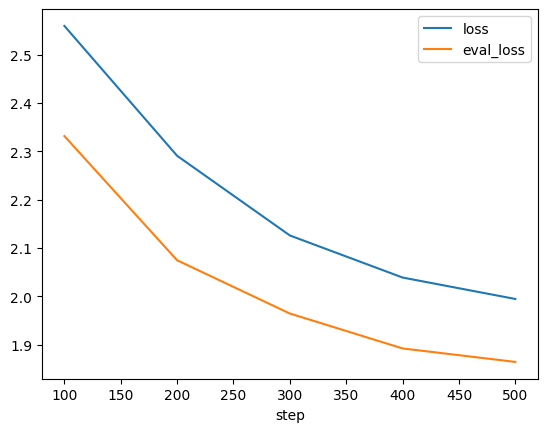

In [16]:
metrics[['loss','eval_loss']].plot();

In [17]:
best_step = metrics['loss'].idxmin()
best_path = os.path.join(output_dir, f'checkpoint-{best_step}')
print(best_path)
metrics.loc[best_step]

./sapiens-vh-finetuned/checkpoint-500


loss                           1.994600
grad_norm                      1.491649
learning_rate                  0.000062
epoch                          8.771930
eval_loss                      1.864437
eval_runtime                   0.834700
eval_samples_per_second     2455.928000
eval_steps_per_second         20.366000
train_runtime                       NaN
train_samples_per_second            NaN
train_steps_per_second              NaN
total_flos                          NaN
train_loss                          NaN
Name: 500, dtype: float64

In [18]:
import sapiens

In [19]:
seq = "QVHPQKSGPRLVKPSETLSLTCAAPGDYIKNNYWPWMRQAAGQGPGWIGRVYSSGTPVLSPSLKNRLTLSVDASKNEVSLNLTSVTAEDAAVYYCARQRWTSDFWGASPDHPFYKYYALDVWGQGTPVTVSS"

probs = sapiens.predict_scores(seq, "H", checkpoint_path=best_path)
probs.head()

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0.005639,0.001395,0.005106,0.046783,0.002029,0.004614,0.003534,0.003295,0.012293,0.004211,0.001872,0.004008,0.012765,0.811382,0.005988,0.050355,0.008335,0.007497,0.002644,0.002212
1,0.010384,0.002993,0.004984,0.007583,0.002712,0.008676,0.002695,0.004927,0.006201,0.024349,0.004167,0.002756,0.005101,0.005267,0.005254,0.005209,0.003846,0.871518,0.012160,0.003740
2,0.007669,0.001700,0.005287,0.111405,0.002641,0.007804,0.031840,0.005330,0.049315,0.016648,0.002636,0.007053,0.027612,0.617947,0.021176,0.025530,0.029667,0.016817,0.004041,0.004906
3,0.003986,0.002310,0.001716,0.003422,0.006247,0.003840,0.002006,0.006810,0.003233,0.836517,0.011753,0.002227,0.033535,0.004211,0.003954,0.004242,0.003089,0.054234,0.002840,0.002427
4,0.002994,0.001844,0.002453,0.039183,0.001386,0.003177,0.002532,0.002209,0.050850,0.006911,0.001667,0.002171,0.005475,0.838390,0.010664,0.005719,0.004339,0.009899,0.002429,0.002093


In [20]:
top = probs.idxmax(axis=1)

print(" Input:", seq)
print("       ", ''.join(' ' if aa == bb else '#' for aa, bb in zip(seq, top)))
print("Output:", ''.join(top))

 Input: QVHPQKSGPRLVKPSETLSLTCAAPGDYIKNNYWPWMRQAAGQGPGWIGRVYSSGTPVLSPSLKNRLTLSVDASKNEVSLNLTSVTAEDAAVYYCARQRWTSDFWGASPDHPFYKYYALDVWGQGTPVTVSS
          ## #   #            ###  # ###  # #   # #  #    #    #####    # # #   #   #   # #    # #       ##### #  # # ### #  ##       #     
Output: QVQLQESGPGLVKPSETLSLTCTVSGDSISSYYWSWIRQAPGKGPEWIGRIYSSGSTNYNPSLKSRVTISVDTSKNQVSLKLSSVTAADTAVYYCARDGYYFDYWGWSGDYYYYYYYGMDVWGQGTTVTVSS


In [21]:
old_probs = sapiens.predict_scores(seq, "H")
old_probs.head()

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0.003016,0.003921,0.003406,0.004417,0.003688,0.003582,0.006578,0.003321,0.004285,0.004148,0.003395,0.003755,0.004619,0.907089,0.004984,0.003558,0.003602,0.003379,0.003470,0.003801
1,0.005750,0.003299,0.004371,0.004711,0.003742,0.006940,0.003500,0.004846,0.003577,0.008997,0.006631,0.003726,0.003119,0.003007,0.003669,0.003065,0.003396,0.899940,0.003987,0.003506
2,0.004966,0.004339,0.005955,0.009716,0.005038,0.005836,0.528618,0.004908,0.009111,0.014517,0.004667,0.006140,0.013755,0.296767,0.033315,0.006002,0.007901,0.004973,0.005106,0.006826
3,0.003515,0.004469,0.002755,0.003611,0.006659,0.003482,0.004024,0.006038,0.003918,0.777746,0.011196,0.003671,0.093331,0.005176,0.015241,0.005265,0.004449,0.017435,0.004670,0.003674
4,0.003643,0.003135,0.003497,0.006288,0.003411,0.003471,0.007734,0.003228,0.006654,0.006174,0.003942,0.003451,0.007147,0.895762,0.009087,0.003666,0.003440,0.004201,0.003622,0.003267


In [22]:
old_top = old_probs.idxmax(axis=1)

print(" Input:", seq)
print("       ", ''.join(' ' if aa == bb else '#' for aa, bb in zip(seq, old_top)))
print("Output:", ''.join(old_top))

 Input: QVHPQKSGPRLVKPSETLSLTCAAPGDYIKNNYWPWMRQAAGQGPGWIGRVYSSGTPVLSPSLKNRLTLSVDASKNEVSLNLTSVTAEDAAVYYCARQRWTSDFWGASPDHPFYKYYALDVWGQGTPVTVSS
           # #   #             ##  #      # #  #     #           ##                 #          # #       #                #           #     
Output: QVHLQESGPGLVKPSETLSLTCAVSGDSIKNNYWSWIRQPAGQGPEWIGRVYSSGTPNYSPSLKNRLTLSVDASKNQVSLNLTSVTAADTAVYYCARDRWTSDFWGASPDHPFYYYYALDVWGQGTTVTVSS
